# Why we use WGAN?
> An case example why we moved from  GAN and WGAN

## Introduction

The [original version of GAN](https://arxiv.org/abs/1406.2661) was released in 2014. It was quite revolutionary and sparked the new line of research that is still very active. What is so revolutionary about GANs? The authors of the paper proposed to train two neural networks (discriminator and generator) stacked against each other in order to overcome the problem of having to create a loss function for the generator. 

Now it seems rather obvious, however, at the time it was a wild idea. And even if it looked mathematically feasible, there was no indication that it could work in practise. Nevertheless, [Ian Goodfellow](https://en.wikipedia.org/wiki/Ian_Goodfellow) and his colleagues demonstrated that such architecture can actually work even with resources at the time. See an examples from the same paper below (Note: images in yellow are the closest exmamples from training dataset)

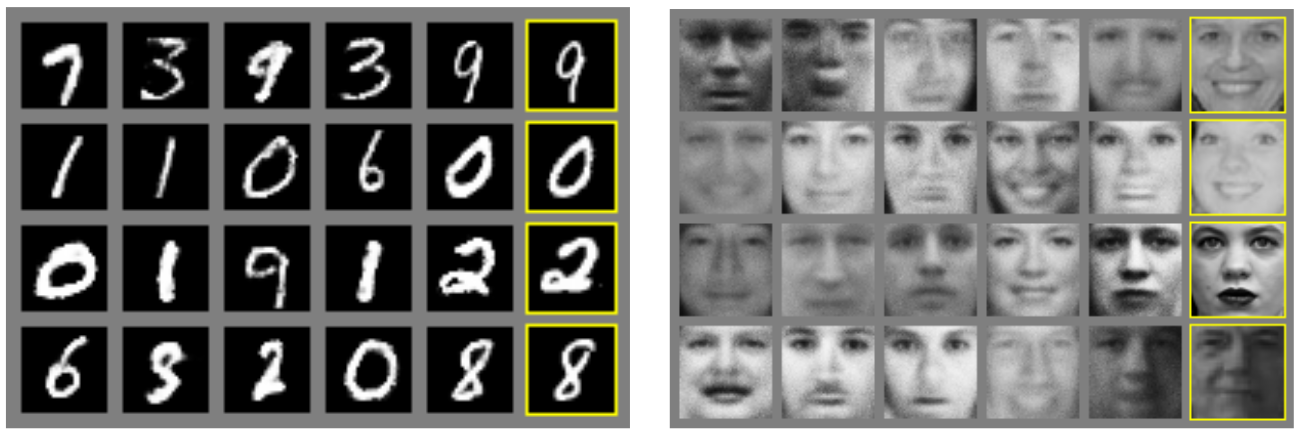 Source: https://arxiv.org/pdf/1406.2661.pdf

In nutshell, generative adversarial networks consist of two networks: generator which generates data points and discriminator that evaluates whether input is coming from training dataset or is generated by generator. It is simple enough, however, it is quite important how the task of discriminator is formulated. That will be the main theme of this post.   

## Original discriminator objective

In the [original version of GAN](https://arxiv.org/abs/1406.2661) measure of real and generated examples was formulated as binary classification: is it real or is it generated. Let's look at the simple case, where we have true distribution (in other words real examples) that consists of 0's. A perfect discriminator will return 1 when input to the discriminator is 0 and output of the discriminator would be 0 otherwise. Despite the fact that discriminator is doing a great job at discriminating between real and generated, however, the generator does not receive meaningful direction for improving. For example, generator output of 0.1 and 1 will be scored the same, even though 0.1 is much closer to real distribution. Let's see this in action.

In [0]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(suppress=False, precision=5)

## Discriminator

In [0]:
def d_loss(d_score_z, d_score_r):
  batch_size = d_score_z.shape[0]
  d_loss_z =tf.keras.losses.binary_crossentropy(tf.zeros(shape = [batch_size,1], dtype=tf.float32), d_score_z)
  d_loss_r =tf.keras.losses.binary_crossentropy(tf.ones(shape = [batch_size,1], dtype=tf.float32), d_score_r)
  return tf.reduce_mean(d_loss_z + d_loss_r)

def define_discriminator(act="sigmoid"):
  d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

  # Discriminator
  discriminator = tf.keras.models.Sequential()
  discriminator.add(tf.keras.layers.Dense(32, activation="relu"))
  discriminator.add(tf.keras.layers.Dense(32, activation="relu"))
  discriminator.add(tf.keras.layers.Dense(1, activation=act))
  return discriminator, d_optimizer

In [0]:
def train_discriminator(discriminator, d_optimizer, d_loss, batch_size = 64):
  real_data = tf.zeros([batch_size, 1])
  # Train discriminator till perfection
  for i in range(1000):
    with tf.GradientTape() as tape:
      z = tf.random.normal(shape=[batch_size, 1])
      d_score_z, d_score_r = discriminator(z), discriminator(real_data)
      total_loss = d_loss(d_score_z, d_score_r)
      if i % 100 == 0:
        print("Total loss:", total_loss.numpy(), "Scores for real:", d_score_r.numpy().mean(), "Scores for generated:", d_score_z.numpy().mean())
      grads = tape.gradient(total_loss, discriminator.trainable_variables)
      d_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

Disclaimer: we are creating an artificial situation just to demonstrate the underlying issue with using binary classification as a loss for discriminator. In reality, we would not train discriminators in this fashion.

In [4]:
discriminator, d_optimizer = define_discriminator()
train_discriminator(discriminator, d_optimizer, d_loss)

Total loss: 1.2753901 Scores for real: 0.5 Scores for generated: 0.43882957
Total loss: 0.07295962 Scores for real: 0.9781779 Scores for generated: 0.015023634
Total loss: 0.014039941 Scores for real: 0.986065 Scores for generated: 7.0891906e-06
Total loss: 0.021772312 Scores for real: 0.9784628 Scores for generated: 5.510665e-11
Total loss: 0.075927064 Scores for real: 0.9949504 Scores for generated: 0.015457453
Total loss: 0.11446469 Scores for real: 0.9977589 Scores for generated: 0.038589276
Total loss: 0.00037504316 Scores for real: 0.99962485 Scores for generated: 4.787702e-14
Total loss: 0.07557466 Scores for real: 0.9988571 Scores for generated: 0.017265305
Total loss: 0.0038048518 Scores for real: 0.9962043 Scores for generated: 2.0079315e-06
Total loss: 0.0021338563 Scores for real: 0.9978684 Scores for generated: 6.928249e-14


So we have got a nearly perfect discriminator that gives 1 for real distribution and 0 for anything else. Let's train the generator using such discriminator.



## Generator

Here we will try to train the generator using perfect discriminator. Again, you would not do that in practise.

In [0]:
def g_loss(x, discriminator=discriminator):
  return tf.reduce_mean(1.0-discriminator(x))

def train_generator(g_loss, batch_size=64):
  g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
  generator = tf.keras.layers.Dense(1, activation='tanh')
  for i in range(1000):
    with tf.GradientTape() as tape:
      z = tf.random.normal(shape=[batch_size, 1])
      gen = generator(z)
      loss = g_loss(gen) 
      if i % 100 == 0:
        print("Loss:", loss.numpy(), "Generator output: ",tf.reduce_mean(tf.abs(gen)).numpy())
      grads = tape.gradient(loss, generator.trainable_variables)
      g_optimizer.apply_gradients(zip(grads, generator.trainable_variables))
  t = plt.scatter(np.zeros(z.shape), z.numpy(), label="True")
  g = plt.scatter(gen.numpy(), z.numpy(), alpha=0.5)
  plt.xlim(-1, 1)
  plt.legend((t,g),("True distribution", "Generated distribution"))  


Loss: 0.98446023 Generator output:  0.5757177
Loss: 1.0 Generator output:  0.62681496
Loss: 0.99996835 Generator output:  0.68048704
Loss: 1.0 Generator output:  0.6950605
Loss: 1.0 Generator output:  0.7098987
Loss: 1.0 Generator output:  0.7288726
Loss: 1.0 Generator output:  0.9237368
Loss: 1.0 Generator output:  0.9254451
Loss: 1.0 Generator output:  0.922577
Loss: 1.0 Generator output:  0.923764


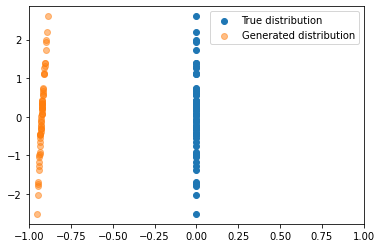

In [6]:
train_generator(g_loss)

It does not converge, the generator does not learn to produce 0's and loss does not decrease. We could find a way to train so that it converges, however, ideally we would want something that would be able to converge in this situation as well.  
 
This issue was described in [famous Wasserstein GAN paper](https://arxiv.org/abs/1701.07875). In this paper authors proposed to change binary classification to something that measures distance between generated outputs and real examples. 
 
Let's try it out with our simplified example.

## WGAN

A very naive approach would be to measure Euclidean distance between real  and generated distributions. Let’s see if that helps.

Loss: 1.8566905 Generator output:  0.19034971
Loss: 0.06090928 Generator output:  0.005873415
Loss: 0.05984832 Generator output:  0.0073457574
Loss: 0.025419286 Generator output:  0.0026790632
Loss: 0.026378132 Generator output:  0.0026014717
Loss: 0.031021483 Generator output:  0.0037481724
Loss: 0.05135456 Generator output:  0.0057523246
Loss: 0.14441356 Generator output:  0.014102172
Loss: 0.059984554 Generator output:  0.0058901818
Loss: 0.053461727 Generator output:  0.0066189137


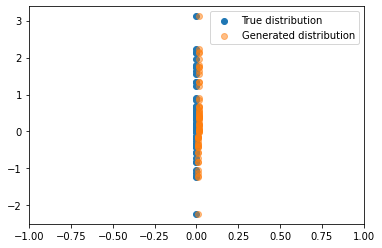

In [7]:
def euclidean_distance(x):
  return tf.reduce_mean(tf.norm(x, 'euclidean'))

train_generator(euclidean_distance)

It works in this example, we can see that loss is decreasing and generator output approaches 0. However, this works in this specific scenario, we can use euclidean distance when we measure the distance between 1D points, but how about images? Hence, for a general solution we will need something that works universally. And that is what [Wasserstein GAN paper](https://arxiv.org/abs/1701.07875) is about. 
 
For the sake of this post, we will skip the details of how and why WGAN works (there are a few brilliant posts about that, please checkout out links in "Further reading" section below), but to put it simply, we can use the distance between the outputs of the discriminator as proxy for distances between distributions. (For this to work, we have to enforce a Lipschitz constraint which we will skip in this post, but will talk about how to enforce it in the next one.)

Let's try it out. 

We measure the distance between the outputs of discriminator by simply subtracting one from another.

In [0]:
def d_loss_wgan(d_score_z, d_score_r):
  return tf.reduce_mean(d_score_z - d_score_r)

In [0]:
discriminator_wgan, d_optimizer = define_discriminator(act=None)
train_discriminator(discriminator_wgan, d_optimizer, d_loss_wgan)

Total loss: -0.20631 Scores for real: 0.0 Scores for generated: -0.20631
Total loss: -92241.375 Scores for real: -128.61824 Scores for generated: -92370.0
Total loss: -1122561.8 Scores for real: -766.5613 Scores for generated: -1123328.2
Total loss: -4381084.5 Scores for real: -1648.9462 Scores for generated: -4382733.5
Total loss: -11101716.0 Scores for real: -2930.0134 Scores for generated: -11104646.0
Total loss: -20111968.0 Scores for real: -2881.5947 Scores for generated: -20114848.0
Total loss: -37373372.0 Scores for real: -2529.8655 Scores for generated: -37375904.0
Total loss: -62526256.0 Scores for real: -10314.391 Scores for generated: -62536570.0
Total loss: -69934790.0 Scores for real: -9289.29 Scores for generated: -69944080.0
Total loss: -135784350.0 Scores for real: -2764.6501 Scores for generated: -135787120.0


Looks like it is working, loss is decreasing (although it is quite unusual to see negative loss).

So now we have discriminator which gives high scores for real examples. So the objective for generator would be to get as high scores as possible, hence we need just `-discriminator(generated)`

Loss: 86786170.0 Generator output:  0.3962338
Loss: 2060925.2 Generator output:  0.009125391
Loss: 2406305.5 Generator output:  0.011163255
Loss: 816975.6 Generator output:  0.0036342242
Loss: 1002175.4 Generator output:  0.004520608
Loss: 1894261.4 Generator output:  0.008713374
Loss: 2398592.2 Generator output:  0.011115221
Loss: 1497964.8 Generator output:  0.007058435
Loss: 2221005.2 Generator output:  0.010142955
Loss: 2540864.5 Generator output:  0.011403117


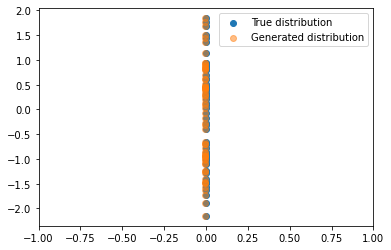

In [0]:
def g_loss_wgan(x):
  return tf.reduce_mean(-discriminator_wgan(x))
train_generator(g_loss_wgan)

Code above actually is in line with WGAN (except, as I mentioned before, we are missing a method to enforce Lipschitz constraint). Three main changes are:
 - we removed sigmoid from the last layer of discriminator because we are not doing classification anymore.
 - we change the loss of discriminator to be the distance between real and generated outputs of discriminator (subtraction will do just fine for measuring distance between 1D points)
 - we change the generator loss to be just opposite to discriminator loss for generated input. 
 
We can see that this algorithm converges and the generated distribution approaches 0. This is all nice and good, however, as you can see, discriminator loss is actually a negative number, hence practitioners more often use some sort of not saturating loss. For example, hinge loss which is defined as follows:

In [0]:
def d_loss_hinge(d_score_z, d_score_r):
    d_loss_real = tf.nn.relu(1.0 - d_score_r) # Note: this changed
    d_loss_fake = tf.nn.relu(1.0 + d_score_z) # Note: this changed
    return tf.reduce_mean(d_loss_real) + tf.reduce_mean(d_loss_fake) 

In [9]:
discriminator_hinge, d_optimizer = define_discriminator(act=None)
train_discriminator(discriminator_hinge, d_optimizer, d_loss_hinge)

Total loss: 2.2130427 Scores for real: 0.0 Scores for generated: 0.21304269
Total loss: 0.046959918 Scores for real: 1.5518551 Scores for generated: -64.95206
Total loss: 0.0864621 Scores for real: 1.9289998 Scores for generated: -83.80411
Total loss: 0.035902765 Scores for real: 2.3413584 Scores for generated: -120.67704
Total loss: 0.06848332 Scores for real: 1.2159318 Scores for generated: -131.21864
Total loss: 0.07119481 Scores for real: 1.7761744 Scores for generated: -161.72647
Total loss: 0.041249227 Scores for real: 1.805813 Scores for generated: -213.31772
Total loss: 0.0 Scores for real: 1.5168437 Scores for generated: -301.31628
Total loss: 0.11920573 Scores for real: 1.8994367 Scores for generated: -270.10626
Total loss: 0.0 Scores for real: 1.4863261 Scores for generated: -312.72998


The same non saturaing principle can be applied to the generator

In [0]:
def g_loss_hinge(x):
  return tf.reduce_mean(tf.nn.relu(1.0-discriminator_hinge(x)))

Loss: 251.17415 Generator output:  0.50602597
Loss: 0.0 Generator output:  0.009517897
Loss: 0.0 Generator output:  0.008805303
Loss: 0.0 Generator output:  0.008805184
Loss: 0.0 Generator output:  0.008802602
Loss: 0.0 Generator output:  0.008800652
Loss: 0.0 Generator output:  0.008805037
Loss: 0.0 Generator output:  0.00880926
Loss: 0.0 Generator output:  0.008802065
Loss: 0.0 Generator output:  0.008806262


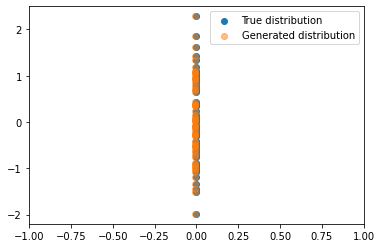

In [11]:
train_generator(g_loss_hinge)

That looks good, we are nearly done, but as I mentioned, we skipped "Lipschitz constraint" piece from [Wasserstein GAN paper](https://arxiv.org/abs/1701.07875). We will focus on this in the next post.

## Summary

I hope now you intuitively understand why we moved from the original GAN to the idea of having the discriminator that measures distance rather than classifying the input. Although the code changes are quite simple, they did improve the stability of the training significantly. And this advancement of GANs played an important role to allow us to generate pictures like that today. 

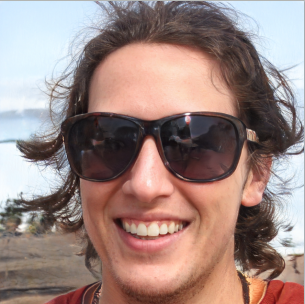

# Further Reading

- [Read-through: Wasserstein GAN](https://www.alexirpan.com/2017/02/22/wasserstein-gan.html)
- [From GAN to WGAN](https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html)
- [GAN — Wasserstein GAN & WGAN-GP](https://medium.com/@jonathan_hui/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490)
